### Imports

In [1]:
%matplotlib widget
%cd ../../..
import logging
logging.basicConfig(level=logging.INFO)
import os
import re

from linetimer import CodeTimer
import matplotlib.pyplot as plt
import nibabel
from nibabel import processing, nifti1, affines
import numpy as np
from skimage.metrics import mean_squared_error, normalized_root_mse

from BabelBrain.GPUFunctions.GPUResample import Resample

/Users/acoreas/opt/miniconda3/envs/bbl_dev/lib/python3.9/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


/Users/acoreas/Documents/GitHub/BabelBrain


### GPU Initialization

In [2]:
# GPUBackend='CUDA'
# GPUBackend='OpenCL'
GPUBackend='Metal'
gpu_name = 'Apple M1 Max'

Resample.InitResample(gpu_name,GPUBackend=GPUBackend)

Selecting device:  Device(gpu, 0)


### Load Input Data

In [3]:
scan_type = 'T1W'
folder_path = '/Users/acoreas/Documents/unit_test_data/SDR_0p31/'
base_name = folder_path + scan_type
fname = base_name + '.nii.gz'
nifti = nibabel.load(fname)
data = nifti.get_fdata()

### Determine Output Data Resolution

In [4]:
# Set desired spatial step
resolution_level = {
    '0': 0.919,    # 200 kHz,   6 PPW
    '1': 0.613,    # 200 kHz,   9 PPW
    '2': 0.459,    # 200 kHz,  12 PPW
    '3': 0.306,    # 600 kHz,   6 PPW
    '4': 0.204,    # 600 kHz,   9 PPW
    '5': 0.153,    # 600 kHz,  12 PPW
    '6': 0.184,    # 1000 kHz,  6 PPW
    '7': 0.123,    # 1000 kHz,  9 PPW
    '8': 0.092,    # 1000 kHz, 12 PPW
}
spatial_step = np.full(3,resolution_level['0'])
# spatial_step = np.asarray(nifti.header.get_zooms())/2
spatial_step_text = re.sub("\.","_",str(spatial_step[0]))

# Calculate new affine
zooms = np.asarray(nifti.header.get_zooms())
print(f"Original zooms: {zooms}")
print(f"New zooms: {spatial_step}")
new_x = int(nifti.shape[0]/(spatial_step[0]/zooms[0]))
new_y = int(nifti.shape[1]/(spatial_step[1]/zooms[1]))
new_z = int(nifti.shape[2]/(spatial_step[2]/zooms[2]))
affine_upscaled = affines.rescale_affine(nifti.affine.copy(),
                                         nifti.shape,
                                         spatial_step,
                                         (new_x,new_y,new_z))

# Output dimensions
output_data = np.zeros((new_x,new_y,new_z),dtype=np.uint8)
output_nifti = nifti1.Nifti1Image(output_data,affine_upscaled)
print(f"Output Dimensions: {output_data.shape}")
print(f"Output Size: {output_data.size}")

Original zooms: [1.0002484  0.99999994 0.99999994]
New zooms: [0.919 0.919 0.919]
Output Dimensions: (204, 278, 278)
Output Size: 15765936


### Run Resample Step

In [ ]:
# Set resample order and mode (default is 3 and 'constant')
order = 3 # 0 or 3
mode = 'constant'

with CodeTimer("GPU Resample", unit="s"):
    resampled_nifti_gpu = Resample.ResampleFromTo(nifti,output_nifti,mode=mode,order=order,cval=data.min(),GPUBackend=GPUBackend)
    resampled_data_gpu = resampled_nifti_gpu.get_fdata()

with CodeTimer("CPU Resample", unit="s"):
    print(f"Starting Resample")
    resampled_fname = base_name + f"_resampled_CPU_mode_{mode}_order_{order}_spatial_step_{spatial_step_text}.nii.gz"
    if os.path.exists(resampled_fname):
        print("Reloading CPU file")
        resampled_data_cpu = nibabel.load(resampled_fname).get_fdata()
    else:
        print("Generating CPU file")
        resampled_nifti = processing.resample_from_to(nifti,output_nifti,mode=mode,order=order,cval=data.min()) # Truth method
        print('Saving CPU file')
        nibabel.save(resampled_nifti,resampled_fname)
        resampled_data_cpu = resampled_nifti.get_fdata()

# Ensure arrays are same size and dtype
if resampled_data_gpu.size != resampled_data_cpu.size:
    print(f"Array sizes don't match: {resampled_data_gpu.size} vs {resampled_data_cpu.size}")
if resampled_data_gpu.size == 0:
    print("Arrays are empty")
if  resampled_data_gpu.dtype != resampled_data_cpu.dtype:
    print("Arrays have different dtypes, changing them to match")
    resampled_data_gpu.astype(resampled_data_cpu.dtype)

INFO:root:
Starting Resample
INFO:root:Step size: 240000000
INFO:root:Total points: 15765936
INFO:root:Working on slices 0 to 204 out of 204


Code block 'GPU Resample' took: 0.25795 s
Starting Resample
Reloading CPU file
Code block 'CPU Resample' took: 0.14020 s


### Plot Data

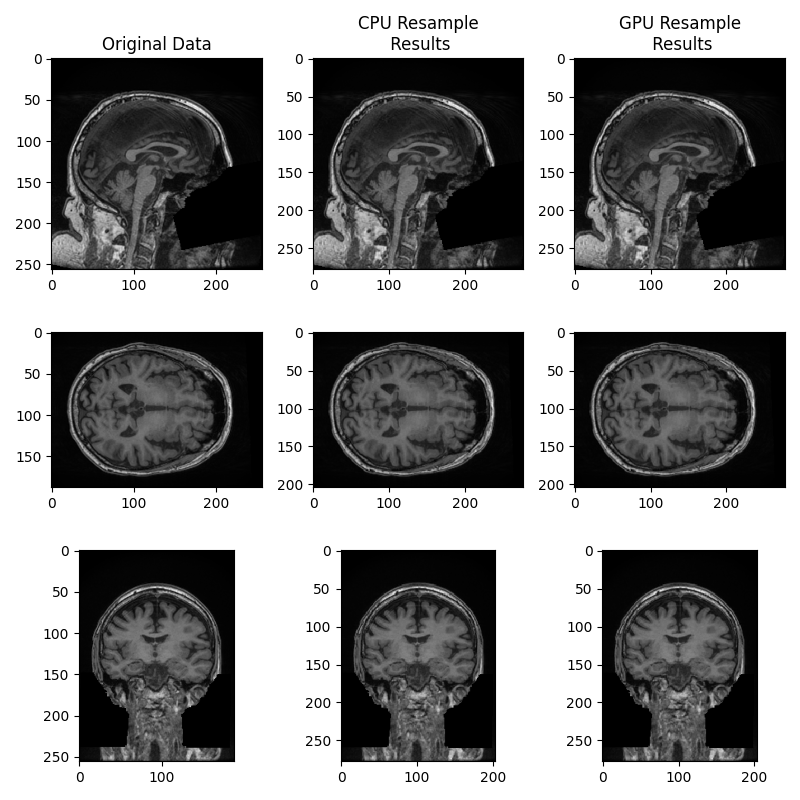

In [6]:
fig, axs = plt.subplots(3, 3, figsize=(8, 8))

slice_num_original = data.shape[0]//2
slice_num_resampled = resampled_data_cpu.shape[0]//2
axs[0,0].set_title("Original Data")
axs[0,0].imshow(np.rot90(data[slice_num_original,:,:]), cmap='gray')
axs[0,1].set_title("CPU Resample\n Results")
axs[0,1].imshow(np.rot90(resampled_data_cpu[slice_num_resampled,:,:]), cmap='gray')
axs[0,2].set_title("GPU Resample\n Results")
axs[0,2].imshow(np.rot90(resampled_data_gpu[slice_num_resampled,:,:]), cmap='gray')

slice_num_original = data.shape[2]//2
slice_num_resampled = resampled_data_cpu.shape[2]//2
axs[1,0].imshow(data[:,:,slice_num_original], cmap='gray')
axs[1,1].imshow(resampled_data_cpu[:,:,slice_num_resampled], cmap='gray')
axs[1,2].imshow(resampled_data_gpu[:,:,slice_num_resampled], cmap='gray')

slice_num_original = data.shape[1]//2
slice_num_resampled = resampled_data_cpu.shape[1]//2
axs[2,0].imshow(np.rot90(data[:,slice_num_original,:]), cmap='gray')
axs[2,1].imshow(np.rot90(resampled_data_cpu[:,slice_num_resampled,:]), cmap='gray')
axs[2,2].imshow(np.rot90(resampled_data_gpu[:,slice_num_resampled,:]), cmap='gray')

# Adjust plots
plt.subplots_adjust(top=0.8,bottom=0.2,wspace=0.1, hspace=0)
plt.tight_layout()


### Check Output Data Matches Truth Data

In [7]:
data_match = np.all(resampled_data_gpu==resampled_data_cpu)
print(f"Data matches? {data_match}")

if not data_match:
    # DICE coefficient calculation
    matches = abs(resampled_data_gpu - resampled_data_cpu) < 1e-6
    matches_count = len(matches[matches==True])
    dice_coeff = 2 * matches_count / (resampled_data_cpu.size + resampled_data_gpu.size)
    print(f"Dice Coefficient: {dice_coeff}")

    # Plot difference images
    diffs = abs(resampled_data_gpu - resampled_data_cpu)

    fig, axs = plt.subplots(3, 1, figsize=(4, 12))

    slice_num = diffs.shape[0]//2
    axs[0].imshow(np.rot90(diffs[slice_num,:,:]), cmap='gray')

    slice_num = diffs.shape[2]//2
    axs[1].imshow(diffs[:,:,slice_num], cmap='gray')

    slice_num = diffs.shape[1]//2
    axs[2].imshow(np.rot90(diffs[:,slice_num,:]), cmap='gray')

    plt.tight_layout()

    # Get difference histograms
    hist,bins = np.histogram(diffs)
    print(f"Difference Histogram")
    for bin in range(len(bins)-1):
        print(f"{bins[bin]:.2f} to {bins[bin+1]:.2f}: {hist[bin]}")

    # Mean square error calculation
    mse = mean_squared_error(resampled_data_cpu,resampled_data_gpu)
    print(f"Mean square error: {mse}")

    # Normalized root mean square error calculation
    nrmse = normalized_root_mse(resampled_data_cpu,resampled_data_gpu,normalization='min-max')
    print(f"Normalized root mean square error: {nrmse}")

Data matches? True
